Plan:
 - write function to generate paths where each path has each step randomly assigned a variance from a distribution
 - write same but this is from a gamma distribution rather than choice from low and high
 - generate sample MC paths from them
 - fit various distributions to see how we clock up

In [1]:
# usual suspects
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import warnings

# some config
%config Completer.use_jedi = False
warnings.filterwarnings('ignore')
sns.set()

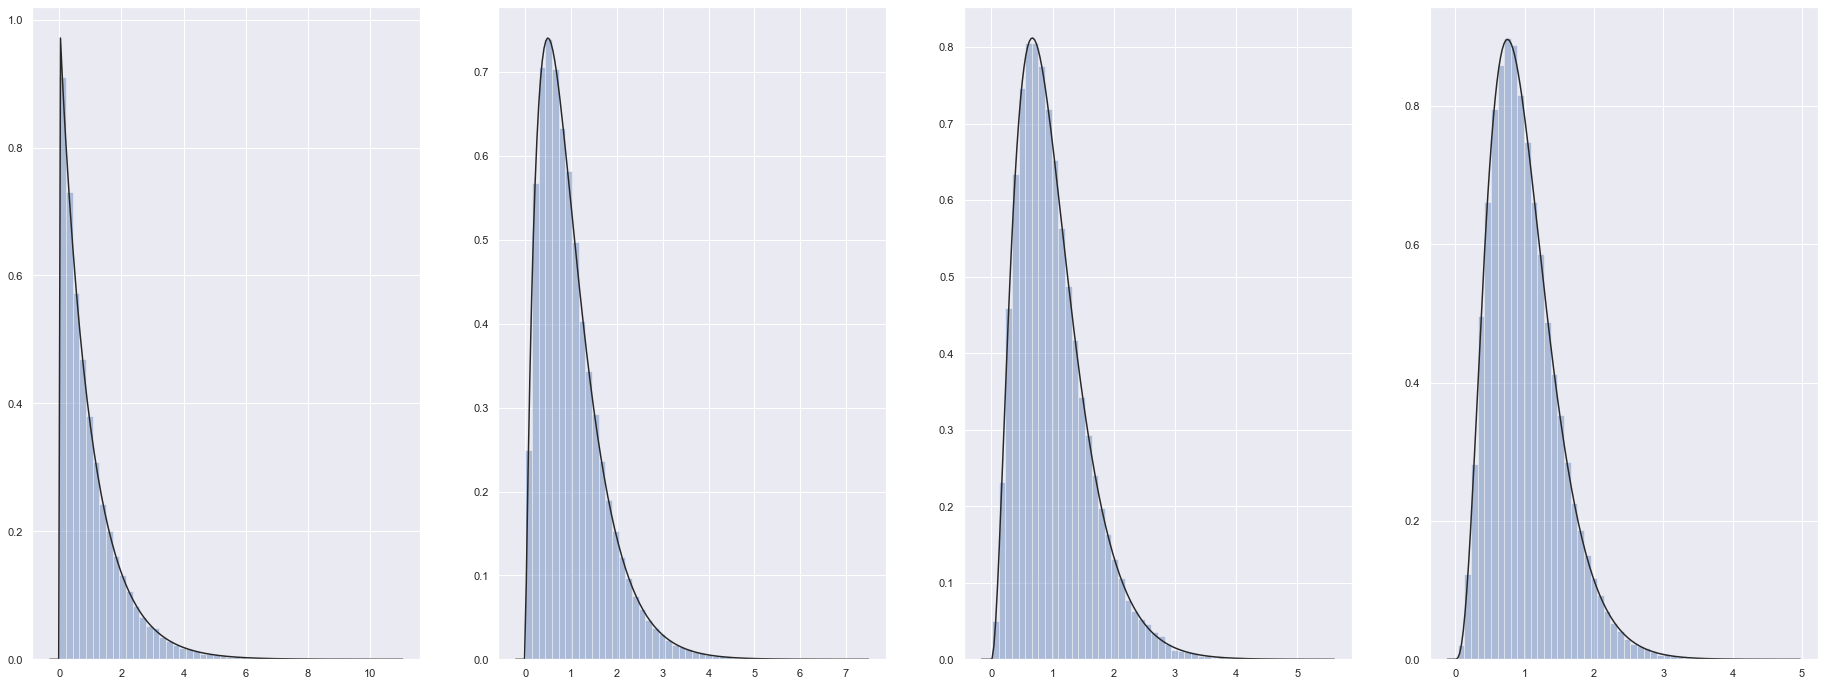

In [17]:
n = 100000
alphas = [1, 2, 3, 4]
gamma_rvs = {}


for a in alphas:
    gamma_rvs[a] = stats.gamma.rvs(a=a, scale=1/a, size=n)

# plot them
fig, axes = plt.subplots(ncols=4, figsize=(32,12))
axes = axes.reshape(-1)

for a, ax in zip(alphas, axes):
    sns.distplot(gamma_rvs[a], kde=False, norm_hist=True, fit=stats.gamma, ax=ax);

In [18]:
[np.mean(x) for x in gamma_rvs.values()]

[0.9993637813031133, 0.9939912946201218, 1.001198722480216, 1.0026932769541248]

In [20]:
[np.var(x) for x in gamma_rvs.values()]

[1.003031888039997,
 0.49220766025227575,
 0.3336973444905345,
 0.2487087532496643]

## Build function to generate paths with gamma variance

In [67]:
# set starting params
spot = 100
drift = 0.00
sigma = 0.20
sims = 10000
points = 250
years = 1

# set gamma variance distribution params
alpha = 0.5

In [125]:
def generate_paths_cust(spot, drift, sigma, years, points, sims, alpha):
    
    rng_spot = np.random.default_rng(seed=123)
    rng_var = np.random.default_rng(seed=321)

    dW = rng_spot.normal(size=(sims, int(points * years)))

    # dX = rng_var.gamma(shape=alpha, scale=1/alpha, size=(sims, int(points * years)))
    # dX = rng_var.standard_t(3, size=(sims, int(points * years)))
    dX = rng_var.pareto(2.07, size=(sims, int(points * years)))

    scaled_dW = (dW * dX) * (sigma / points**0.5)
    # scaled_dW = dW * (sigma / points**0.5)
    # add on the drift
    daily_devs = (drift / points) + scaled_dW
    # cumsum them as log returns additive
    cum_rets = np.cumsum(daily_devs, axis=1)
    # add in 0 at start for starting price
    cum_rets = np.insert(cum_rets, 0, 0, axis=1)
    # create price series
    pxs = spot * np.exp(cum_rets)
    # return the goodies
    return daily_devs, pxs

In [126]:
rets, pxs = generate_paths_cust(spot, drift, sigma, years, points, sims, alpha)

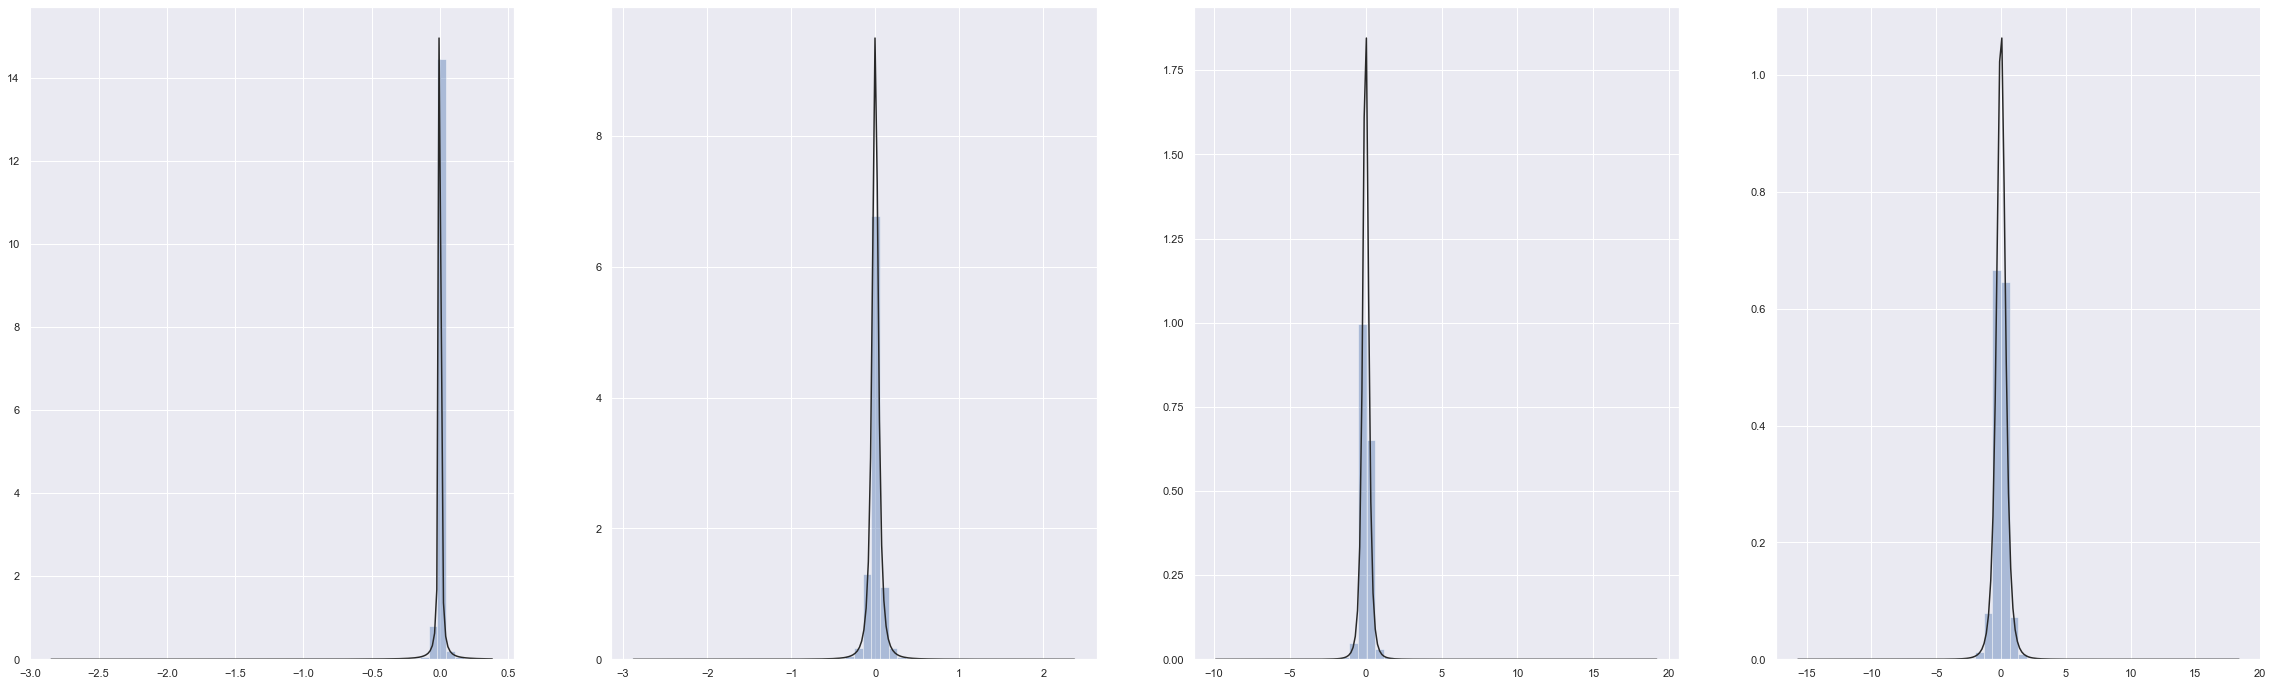

In [130]:
# plot them
fig, axes = plt.subplots(ncols=4, figsize=(40,12))
axes = axes.reshape(-1)

# plot hist and pdf to see if they aline
sns.distplot(np.log(pxs[:,1]/100), kde=False, norm_hist=False, fit=stats.t, ax=axes[0])
sns.distplot(np.log(pxs[:,10]/100), kde=False, norm_hist=False, fit=stats.t, ax=axes[1])
sns.distplot(np.log(pxs[:,100]/100), kde=False, norm_hist=False, fit=stats.t, ax=axes[2])
sns.distplot(np.log(pxs[:,-1]/100), kde=False, norm_hist=False, fit=stats.t, ax=axes[3]);

In [128]:
np.var(np.log(pxs[:-1]/100))

0.1934305333892156

array([[-0.01335862, -0.00473737,  0.01181907, ...,  0.00062028,
         0.03107418,  0.01107736],
       [-0.00763023, -0.00851515,  0.01427665, ..., -0.0176332 ,
        -0.00374807, -0.01619917],
       [-0.00404017,  0.00249028,  0.01122662, ...,  0.00808535,
        -0.00143951, -0.01086108],
       ...,
       [ 0.00137748, -0.01490966,  0.00120227, ..., -0.03810328,
         0.00270378,  0.00569315],
       [ 0.00939778, -0.00093126, -0.00100539, ..., -0.02869895,
        -0.00132867, -0.01035268],
       [-0.01473014, -0.00673646, -0.03103929, ...,  0.0087684 ,
         0.00494433, -0.00679063]])

In [29]:
dX.shape

(1000, 250)

In [ ]:
# create random numbers
dW = rng.normal(size=(sims, int(points * years)))
rng.

In [ ]:
rng = np.random.default_rng(seed=123)
# create random numbers
dW = rng.normal(size=(sims, int(points * years)))
# get our scaled random deviations
scaled_dW = dW * (sigma / points**0.5)
# add on the drift
daily_devs = (drift / points) + scaled_dW
# cumsum them as log returns additive
cum_rets = np.cumsum(daily_devs, axis=1)
# add in 0 at start for starting price
cum_rets = np.insert(cum_rets, 0, 0, axis=1)
# create price series
pxs = spot * np.exp(cum_rets)
# return the goodies
return daily_devs, pxs